### Inplay overround movement
1. Following method to stream historic data
2. Anaylsing the overround inplay

How efficient is the market inplay? If overround differs largely from 1, there is value in laying all horses at once.

The below follows all steps from `/notebooks/historic_data_formatting/3_betfair_advanced_data_month_dataframe_version.ipynb` to retrieve data.

In [2]:
import betfairlightweight
from betfairlightweight import filters
import pandas as pd
import numpy as np
import os
import datetime
import json
from pathlib import Path, PurePath #To define open and save locations that are cross-compatible between Windows/Linux
from bz2 import BZ2File #To unzip the Betfair data from its downloaded format
import matplotlib.pyplot as plt

project_dir = Path.cwd().parents[1]
logins_dir = project_dir / 'api_logins.json'

with open(logins_dir) as f:
    login_dict =  json.load(f)
    
trading = betfairlightweight.APIClient(username=login_dict['my_username'],
                                       password=login_dict['my_password'],
                                       app_key=login_dict['my_app_key'],
                                       certs=login_dict['certs_path'])

trading.login()

<LoginResource>

In [3]:
my_data = trading.historic.get_my_data()
for i in my_data:
    print(i)

{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-01-01T00:00:00', 'purchaseItemId': 41610}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-02-01T00:00:00', 'purchaseItemId': 41610}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-03-01T00:00:00', 'purchaseItemId': 41610}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-04-01T00:00:00', 'purchaseItemId': 41610}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-05-01T00:00:00', 'purchaseItemId': 41610}
{'sport': 'Horse Racing', 'plan': 'Pro Plan', 'forDate': '2020-04-01T00:00:00', 'purchaseItemId': 41353}
{'sport': 'Horse Racing', 'plan': 'Pro Plan', 'forDate': '2020-05-01T00:00:00', 'purchaseItemId': 41353}


The following selects just the data for from 01/01/20 to 01/03/20 and returns a dictionary of the contents of the data which we go on to use to download specific country/race/market types, and tells us the size of the entire selection:

In [4]:
file_list = trading.historic.get_file_list(
    "Horse Racing",
    "Advanced Plan",
    from_day=1,
    from_month=2,
    from_year=2020,
    to_day=1,
    to_month=2,
    to_year=2020,
    market_types_collection=["WIN"],
    countries_collection=["GB"],
    file_type_collection=["M"],
)
print(file_list)

['/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130661.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096552.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136214.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133543.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130666.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096559.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136219.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130671.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133548.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096566.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136224.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133553.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130676.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168130245.bz2', '/xds

To downoad a file, `download_file()` is used, where we specify the download location (on Betfair) in `file_path` and the directory to which it is saved in `store_directory`. The filename is kept as is from Betfair. We both download the file and use the command to assign the file's location to the variable `download` so we can use it in subsequent operations. `file_path` below is a list input over which we iterate `.download_file()`.

In [9]:
data_dir = project_dir / 'data' / 'raw' / 'api'

available_files = file_list[:1]

downloaded_files = [] #list of directories of each download

for file in available_files:
    download = trading.historic.download_file(file_path = file, store_directory = data_dir)
    print(download)
    downloaded_files.append(download)

C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168130661.bz2


The downloaded file is .json formatted compressed in a bzip2 (.bz2) folder. The following extracts the file where it is downloaded. It is given no file extension, however it remains in .txt format and is readable in any text reader.

In [10]:
extracted_files = []

for file in downloaded_files:
    zipfile = BZ2File(file) # open the file
    data = zipfile.read() # get the decompressed data
    newfilepath = file.split('.bz2')[0] # removing the extension and saving without a filetype
    open(newfilepath, 'wb').write(data) # write an uncompressed file
    extracted_files.append(newfilepath)
    zipfile.close()
    
print(extracted_files)

['C:\\Users\\Asus\\OneDrive\\python\\betfair_project\\data\\raw\\api\\1.168130661']


## Using stream listener to read extracted data

We now have a readable raw text file in Betfair's dictionary format. To interpret the data with python, betfairlightweight includes a stream listener which will interpret the input of historical data in the same way that it does for live data. The below is edited from [here](https://github.com/liampauling/betfair/blob/104ff4cb8734038cb9351e74d16dc7bd018111bc/examples/examplestreaminghistorical.py). 

This finds the chosen variables in the data file and outputs them in a .csv format in output.txt. Note: output.txt is ignored by git and is not uploaded into the repository.

In [11]:
from betfairlightweight import StreamListener
from betfairlightweight.streaming.stream import MarketStream

class HistoricalStream(MarketStream):
    # create custom listener and stream

    def __init__(self, listener):
        super(HistoricalStream, self).__init__(listener)

    def on_process(self, market_books):
        for market_book in market_books:
            for runner in market_book.runners:
                time.append(market_book.publish_time)
                marketid.append(float(market_book.market_id))
                status.append(market_book.status)
                inplay.append(market_book.inplay)
                selectionid.append(runner.selection_id)
                lastpricetraded.append(runner.last_price_traded)
                totalmatched.append(runner.total_matched)
                sp.append(runner.sp.actual_sp)
                adjfactor.append(runner.adjustment_factor)
                runnerstatus.append(runner.status)
                mkttotalmatched.append(market_book.total_matched)

time = []
marketid = []
status = []
inplay = []
selectionid = []
lastpricetraded = []
totalmatched = []
sp = []
adjfactor = []
runnerstatus = []
mkttotalmatched = []
        
datadict = {'Time': time, 'MarketId' : marketid, 'Status' : status, 'Inplay' : inplay, \
    'SelectionId' : selectionid, 'LastPriceTraded' : lastpricetraded, 'TotalMatched' : totalmatched, \
    'Sp' : sp, 'AdjFactor' :  adjfactor, 'RunnerStatus' : runnerstatus, 'MktTotalMatched' : mkttotalmatched}

class HistoricalListener(StreamListener):
    def _add_stream(self, unique_id, stream_type):
        if stream_type == "marketSubscription":
            return HistoricalStream(self)
        
listener = HistoricalListener(max_latency=None)

for file in extracted_files:
    stream = trading.streaming.create_historical_stream(
        directory=file,
        listener=listener,
    )
    stream.start() 
    print(str(file) + " stream completed.")

C:\Users\Asus\OneDrive\python\betfair_project\data\raw\api\1.168130661 stream completed.


We can now view the data:

In [26]:
df = pd.DataFrame(datadict)
df.head()

,Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded,TotalMatched,Sp,AdjFactor,RunnerStatus,MktTotalMatched
0,2020-01-31 11:41:45.697,1.168131,OPEN,False,25545675,0.0,0.0,NaN,5.95,ACTIVE,NaN
1,2020-01-31 11:41:45.697,1.168131,OPEN,False,25238892,0.0,0.0,NaN,30.53,ACTIVE,NaN
2,2020-01-31 11:41:45.697,1.168131,OPEN,False,24707172,0.0,0.0,NaN,7.01,ACTIVE,NaN
3,2020-01-31 11:41:45.697,1.168131,OPEN,False,24420205,0.0,0.0,NaN,8.45,ACTIVE,NaN
4,2020-01-31 11:41:45.697,1.168131,OPEN,False,26314798,0.0,0.0,NaN,33.12,ACTIVE,NaN


In [27]:
df['TradeSize'] = df.groupby(['MarketId','SelectionId', 'LastPriceTraded'])['TotalMatched'].diff()

In [28]:
%time

# converting to datetime
df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')

# calculating inplay start for each race (assigning to new columns)
df['start_time'] = df['Time'].where(df['Inplay'] == True).groupby(df['MarketId']).transform('min')

# calculating difference between each time point and start time
df['time_dif'] = (df['Time'] - df['start_time']).astype('timedelta64[s]')

df = df.drop('start_time', 1)

Wall time: 0 ns


In [34]:
# filtering out price points with zero 'size'
df = df[df['LastPriceTraded'] != 0]
df = df[(df['Inplay'] == True) & (df['Status'] == "OPEN")]

### Inplay overround
* Find the implied probability of each horse
* Plot


In [35]:
df['Odds'] = df['LastPriceTraded'].apply(lambda x: 1/x)

df['Overround'] = df.groupby('time_dif')['Odds'].transform('sum')

In [36]:
df.head()

,Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded,TotalMatched,Sp,AdjFactor,RunnerStatus,MktTotalMatched,TradeSize,time_dif,Odds,Overround
58824,2020-02-01 12:35:45.684,1.168131,OPEN,True,25545675,50.00,5611.69,55.00,2.38,ACTIVE,421373.9,0.0,0.0,0.020000,0.992649
58825,2020-02-01 12:35:45.684,1.168131,OPEN,True,25238892,2.54,196339.73,2.47,38.46,ACTIVE,421373.9,0.0,0.0,0.393701,0.992649
58826,2020-02-01 12:35:45.684,1.168131,OPEN,True,24707172,10.50,14670.28,11.00,6.66,ACTIVE,421373.9,0.0,0.0,0.095238,0.992649
58827,2020-02-01 12:35:45.684,1.168131,OPEN,True,24420205,11.00,16654.91,12.00,7.14,ACTIVE,421373.9,0.0,0.0,0.090909,0.992649
58828,2020-02-01 12:35:45.684,1.168131,OPEN,True,26314798,3.55,153695.26,3.55,35.34,ACTIVE,421373.9,0.0,0.0,0.281690,0.992649


Text(0, 0.5, 'Overround')

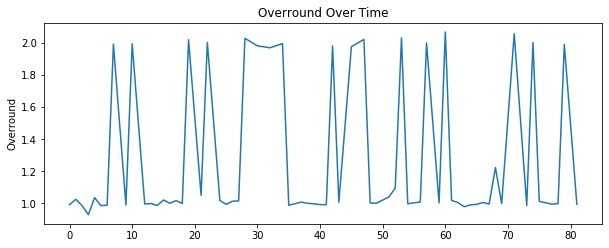

In [38]:
plt.figure(figsize=(10,5))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(df['time_dif'], df['Overround']) 

#top.axes.get_xaxis().set_visible(False)
top.set_title('Overround Over Time')
top.set_ylabel('Overround')